# [Sutton and Barto Notebooks](https://github.com/seungjaeryanlee/sutton-barto-notebooks): Figure 2.4

[모두AI](https://www.modu.ai)  
Author: Ryan Lee  
저자: 이승재  

![Figure 2.4](figure_2_4.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def argmax_all(list_):
    """
    Returns all argmax of given list in a list. Different from np.argmax which 
    returns first instance only.
    주어진 list의 최대값들의 index들을 list 형태로 반환합니다. 첫 최대값의 index만 반환하는
    np.argmax와는 다릅니다.
    """
    return np.argwhere(list_ == list_.max()).flatten()

## Environment

![Figure 2.1](figure_2_1.png)

In [3]:
class Environment:
    """
    The 10-armed Testbed environment shown in Figure 2.1.
    Figure 2.1에서 보여진 10개의 행동이 가능한 Bandit입니다.
    """
    def __init__(self, n_actions=10):
        self.action_space = [i for i in range(n_actions)]
        self.distributions = []
        for _ in range(n_actions):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

    def step(self, action):
        """
        Returns the reward of the given action.
        주어진 행동에 대한 보상을 반환합니다.
        """
        mean, stddev = self.distributions[action]
        reward = np.random.normal(loc=mean, scale=stddev)
        return reward

    def reset(self):
        """
        Reset the reward distributions of the environment.
        환경의 보상 분포들을 재설정합니다.
        """
        self.distributions = []
        for _ in range(len(self.action_space)):
            mean = np.random.normal(0, 1)
            stddev = 1
            self.distributions.append((mean, stddev))

        self.optimal_action = np.argmax([d[0] for d in self.distributions])

## Agents

These are implementations of the Bandit algorithms specified in the book. In other words, we don't use learning rate $\alpha$.  
책에 포함된 밴딧 알고리즘을 구현했습니다. 즉, 학습율 $\alpha$ 을 쓰지 않는 알고리즘입니다.  

In [4]:
class EpsilonGreedyAgent:
    """
    An e-greedy agent.
    엡실론 탐욕 에이전트입니다.
    """

    def __init__(self, action_space, epsilon=0, name=None):
        self.action_space = action_space
        self.q = np.zeros(len(action_space))
        self.action_counts = np.zeros(len(action_space), dtype=int)
        self.epsilon = epsilon
        self.name = '$e$ = {}'.format(epsilon) if name is None else name

    def get_action(self):
        """
        Choose action with epsilon-greedy policy.
        엡실론 탐욕 정책으로 행동을 선택합니다.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            return np.random.choice(argmax_all(self.q))

    def update_q(self, action, reward):
        """
        Update appropriate Q value with given action and reward.
        주어진 행동과 보상으로 Q값을 업데이트합니다.
        """
        self.action_counts[action] += 1
        self.q[action] += (reward - self.q[action]) / \
            self.action_counts[action]

    def reset(self):
        """
        Reset agent's Q values to 0.
        에이전트의 Q값들을 0으로 재설정합니다.
        """
        self.q = np.zeros(len(self.action_space))
        self.sum_rewards = np.zeros(len(self.action_space))
        self.action_counts = np.zeros(len(self.action_space), dtype=int)

For reference, here is the Upper Confidence Bound (UCB) algorithm.  
참조를 위해 UCB 알고리즘을 포함하였습니다.  

$$
A_t = \text{argmax}_a \bigg[ Q_t(a) + c \sqrt{\frac{\log t}{N_t(a)}} \bigg]
$$

In [5]:
class UCBAgent:
    """
    An Upper Confidence Bound agent.
    UCB 에이전트입니다.
    """

    def __init__(self, action_space, ucb_c=0, name=None):
        self.action_space = action_space
        self.q = np.zeros(len(action_space))
        self.total_action = 0
        self.action_counts = np.zeros(len(action_space), dtype=int)
        self.ucb_c = ucb_c
        self.name = '$c$ = {}'.format(ucb_c) if name is None else name

    def get_action(self):
        """
        Choose action greedily with UCB action selection.
        UCB로 탐욕적으로 행동을 선택합니다.
        """
        ucb_terms = np.zeros(len(self.action_space))
        for action in self.action_space:
            if self.action_counts[action] == 0:
                ucb_terms[action] = float("inf")
            else:
                sqrt_term = np.sqrt(
                    np.log(self.total_action) / self.action_counts[action])
                ucb_terms[action] = (self.ucb_c * sqrt_term)

        best_actions = argmax_all(self.q + ucb_terms)

        return np.random.choice(best_actions)

    def update_q(self, action, reward):
        """
        Update appropriate Q value with given action and reward.
        주어진 행동과 보상으로 Q값을 업데이트합니다.
        """
        self.total_action += 1
        self.action_counts[action] += 1
        self.q[action] += (reward - self.q[action]) / \
            self.action_counts[action]

    def reset(self):
        """
        Reset agent's Q values to 0.
        에이전트의 Q값들을 0으로 재설정합니다.
        """
        self.q = np.zeros(len(self.action_space))
        self.sum_rewards = np.zeros(len(self.action_space))
        self.action_counts = np.zeros(len(self.action_space), dtype=int)

## Plots

In [6]:
def run(env, agent, n_steps=1000):
    """
    Take actions on the bandit environment. This is called a "run".
    Bandit 환경에서 n_steps 번 행동을 합니다. 이것을 하나의 '실행'이라 합니다.
    """
    actions = np.zeros(n_steps, dtype=int)
    rewards = np.zeros(n_steps)
    for i in range(n_steps):
        actions[i] = agent.get_action()
        rewards[i] = env.step(actions[i])
        agent.update_q(actions[i], rewards[i])

    return (actions, rewards)

In [7]:
def runs(env, agent, n_runs=2000, n_steps=1000):
    """
    Perform multiple runs on given environment and agent, resetting
    environment and agent after every run. Resetting environment
    changes the actions' reward distributions, and resetting the
    agent resets its Q values.
    주어진 환경과 에이전트로 여러 번 실행합니다. 각 실행마다 환경과 에이전트는
    초기화됩니다. 환경이 초기화되면 각 행동들의 보상 분포가 바뀌고, 에이전트가
    초기화되면 Q값이 초기화됩니다.
    """
    sum_rewards = np.zeros(n_steps)
    optimal_action_counts = np.zeros(n_steps)

    for i in range(n_runs):
        env.reset()
        agent.reset()

        actions, rewards = run(env, agent, n_steps)

        sum_rewards = np.add(sum_rewards, rewards)

    return sum_rewards / n_steps

In [8]:
def plot(agents, n_runs, n_steps):
    """
    Plot a graph of average rewards throughout runs for agents specified by
    their epsilon values.
    실행들 동안 각 시간 스텝의 평균 보상을 나타내는 그래프를 그립니다.
    """
    plt.xlabel('Steps')
    plt.ylabel('Average reward', rotation='horizontal', ha='right')
    
    names = []
    for agent in agents:
        names.append(agent.name)
        env = Environment()
        avg_rewards = runs(env, agent, n_runs, n_steps)
        plt.plot(avg_rewards)

    plt.legend(names)
    # plt.savefig('plot.png')
    plt.show()

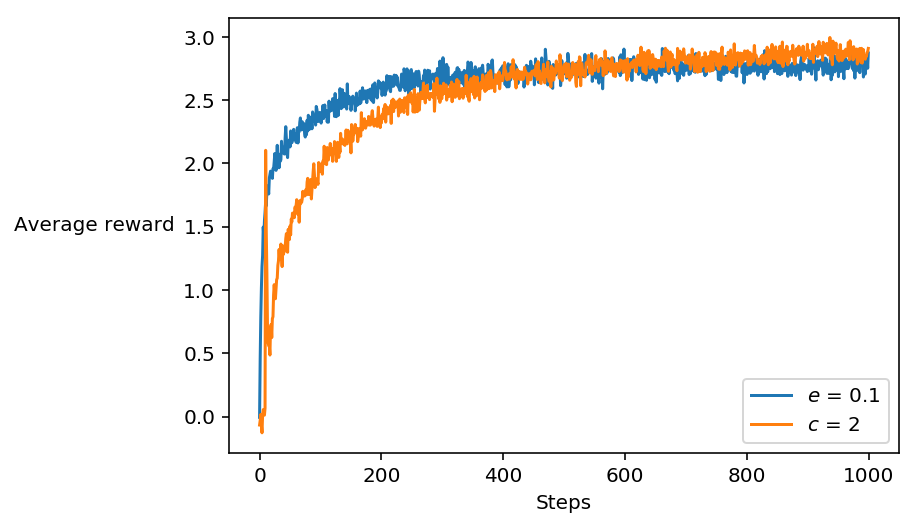

In [9]:
env = Environment()
agents = [
    EpsilonGreedyAgent(env.action_space, epsilon=0.1),
    UCBAgent(env.action_space, ucb_c=2)
]

plot(agents, n_runs=2000, n_steps=1000)

*Exercise 2.8: UCB Spikes*

In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: if c = 1, then the spike is less prominent.

Figure 2.4에서 UCB 알고리즘은 11번째 스텝에서 큰 변동폭이 있습니다. 이 이유는 무엇일까요? 완전한 답변은 보상이 11번째 스텝에서 왜 증가하는지, 또 그 후에 왜 감소하는지 설명해야 합니다.